# EM Algorithm

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from math import *
from pylab import *

## 1. Lecture des données

In [3]:
def read_file ( filename ):
    """
    Lit le fichier contenant les données du geyser Old Faithful
    """
    # lecture de l'en-tête
    infile = open ( filename, "r" )
    for ligne in infile:
        if ligne.find ( "eruptions waiting" ) != -1:
            break

    # ici, on a la liste des temps d'éruption et des délais d'irruptions
    data = []
    for ligne in infile:
        if ligne.strip():
            nb_ligne, eruption, waiting = [ float (x) for x in ligne.split () ]
            data.append ( eruption )
            data.append ( waiting )
    infile.close ()

    # transformation de la liste en tableau 2D
    data = np.asarray ( data )
    data.shape = (data.size / 2, 2 )

    return data

data = read_file ( "2015_tme4_faithful.txt" )
#print (data)

/home/like/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:22: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


## 2. Loi normale bidimensionnelle

In [4]:
def normale_bidim ( x, z, tuplet ):
    ux = tuplet[0]
    uz = tuplet[1]
    sigmaX = tuplet[2]
    sigmaZ = tuplet[3]
    p = tuplet[4]
    a = 1/(2*math.pi*sigmaX*sigmaZ*math.sqrt(1-p*p))
    b=-1/(1-p*p)/2
    c=((x-ux)/sigmaX)*((x-ux)/sigmaX)
    d=2*p*(x-ux)*(z-uz)/sigmaX/sigmaZ
    e=((z-uz)/sigmaZ)*((z-uz)/sigmaZ)
    f=math.exp(b*(c-d+e))
    g=a*f
    return g

In [6]:
print (normale_bidim( 1, 2, [1.0,2.0,3.0,4.0,0]))
print (normale_bidim( 1, 0, [1.0,2.0,1.0,2.0,0.7]))

0.013262911924324612
0.0418047994276145


## 3. Visualisation de loi normale bidimensionnelle

In [7]:
def dessine_1_normale ( params ):
    # récupération des paramètres
    mu_x, mu_z, sigma_x, sigma_z, rho = params

    # on détermine les coordonnées des coins de la figure
    x_min = mu_x - 2 * sigma_x
    x_max = mu_x + 2 * sigma_x
    z_min = mu_z - 2 * sigma_z
    z_max = mu_z + 2 * sigma_z

    # création de la grille
    x = np.linspace ( x_min, x_max, 100 )
    z = np.linspace ( z_min, z_max, 100 )
    X, Z = np.meshgrid(x, z)

    # calcul des normales
    norm = X.copy ()
    for i in range ( x.shape[0] ):
        for j in range ( z.shape[0] ):
            norm[i,j] = normale_bidim ( x[i], z[j], params )

    # affichage
    fig = plt.figure ()
    plt.contour ( X, Z, norm, cmap=cm.autumn )
    plt.show ()

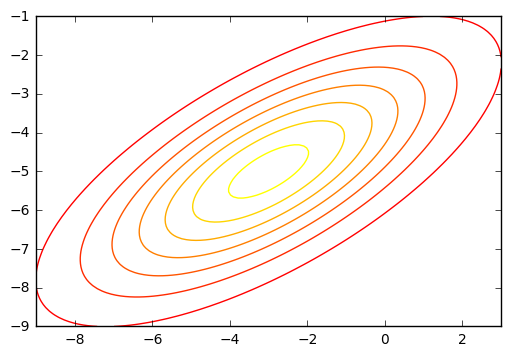

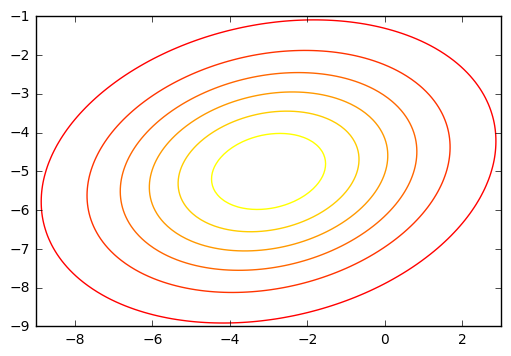

In [8]:
dessine_1_normale ( (-3.0,-5.0,3.0,2.0,0.7) )
dessine_1_normale ( (-3.0,-5.0,3.0,2.0,0.2) )

## 4. Visualisation des données du Old Faithfu

In [9]:
def dessine_normales ( data, params, weights, bounds, ax ):
    # récupération des paramètres
    mu_x0, mu_z0, sigma_x0, sigma_z0, rho0 = params[0]
    mu_x1, mu_z1, sigma_x1, sigma_z1, rho1 = params[1]

    # on détermine les coordonnées des coins de la figure
    x_min = bounds[0]
    x_max = bounds[1]
    z_min = bounds[2]
    z_max = bounds[3]

    # création de la grille
    nb_x = nb_z = 100
    x = np.linspace ( x_min, x_max, nb_x )
    z = np.linspace ( z_min, z_max, nb_z )
    X, Z = np.meshgrid(x, z)

    # calcul des normales
    norm0 = np.zeros ( (nb_x,nb_z) )
    for j in range ( nb_z ):
        for i in range ( nb_x ):
            norm0[j,i] = normale_bidim ( x[i], z[j], params[0] )# * weights[0]
    norm1 = np.zeros ( (nb_x,nb_z) )
    for j in range ( nb_z ):
        for i in range ( nb_x ):
             norm1[j,i] = normale_bidim ( x[i], z[j], params[1] )# * weights[1]

    # affichages des normales et des points du dataset
    ax.contour ( X, Z, norm0, cmap=cm.winter, alpha = 0.5 )
    ax.contour ( X, Z, norm1, cmap=cm.autumn, alpha = 0.5 )
    for point in data:
        ax.plot ( point[0], point[1], 'k+' )


In [10]:
def find_bounds ( data, params ):
    # récupération des paramètres
    mu_x0, mu_z0, sigma_x0, sigma_z0, rho0 = params[0]
    mu_x1, mu_z1, sigma_x1, sigma_z1, rho1 = params[1]

    # calcul des coins
    x_min = min ( mu_x0 - 2 * sigma_x0, mu_x1 - 2 * sigma_x1, data[:,0].min() )
    x_max = max ( mu_x0 + 2 * sigma_x0, mu_x1 + 2 * sigma_x1, data[:,0].max() )
    z_min = min ( mu_z0 - 2 * sigma_z0, mu_z1 - 2 * sigma_z1, data[:,1].min() )
    z_max = max ( mu_z0 + 2 * sigma_z0, mu_z1 + 2 * sigma_z1, data[:,1].max() )

    return ( x_min, x_max, z_min, z_max )

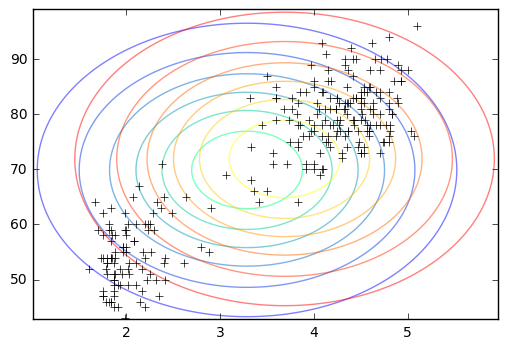

In [11]:
# affichage des données : calcul des moyennes et variances des 2 colonnes
mean1 = data[:,0].mean ()
mean2 = data[:,1].mean ()
std1  = data[:,0].std ()
std2  = data[:,1].std ()

# les paramètres des 2 normales sont autour de ces moyennes
params = np.array ( [(mean1 - 0.2, mean2 - 1, std1, std2, 0),
                     (mean1 + 0.2, mean2 + 1, std1, std2, 0)] )
weights = np.array ( [0.4, 0.6] )
bounds = find_bounds ( data, params )

# affichage de la figure
fig = plt.figure ()
ax = fig.add_subplot(111)
dessine_normales ( data, params, weights, bounds, ax )
plt.show ()

## 5. EM : l'étape E

In [12]:
def Q_i ( data, current_params, current_weights ):
	n=len(data)
	T=np.eye(n,2)
	
	for i in range(n):
		x=data[i][0]
		z=data[i][1]
		a0=normale_bidim ( x, z,current_params[0] )*current_weights[0]
		a1=normale_bidim ( x, z,current_params[1] )*current_weights[1]
		T[i][0]=a0/(a0+a1)
		T[i][1]=a1/(a0+a1)
	return T

In [14]:
current_params = np.array([[ 3.28778309, 69.89705882, 1.13927121, 13.56996002, 0. ],
                           [ 3.68778309, 71.89705882, 1.13927121, 13.56996002, 0. ]])
current_weights = np.array ( [ 0.5, 0.5 ] )


current_params = np.array([[ 3.2194684, 67.83748075, 1.16527301, 13.9245876,  0.9070348 ],
                           [ 3.75499261, 73.9440348, 1.04650191, 12.48307362, 0.88083712]])
current_weights = np.array ( [ 0.49896815, 0.50103185] )

T = Q_i ( data, current_params, current_weights )
#print (T)

## 6. EM : l'étape M

In [15]:
def M_step ( data, Q, current_params, current_weights ):
    n=len(data)
    c0=Q[:,0].sum()
    c1=Q[:,1].sum()
    s=c0+c1
    pi0=c0/s
    pi1=c1/s
	
    mux0=Q[:,0].dot(data[:,0])/c0
    mux1=Q[:,1].dot(data[:,0])/c1
    muz0=Q[:,0].dot(data[:,1])/c0
    muz1=Q[:,1].dot(data[:,1])/c1
	
    x_u0=data[:,0]-np.array([mux0]*n) 
    x_u1=data[:,0]-np.array([mux1]*n)
    z_u0=data[:,1]-np.array([muz0]*n)
    z_u1=data[:,1]-np.array([muz1]*n)
	
    sigmaX0=Q[:,0].dot(x_u0*x_u0)
    sigmaX1=Q[:,1].dot(x_u1*x_u1)
    sigmaZ0=Q[:,0].dot(z_u0*z_u0)
    sigmaZ1=Q[:,1].dot(z_u1*z_u1)
	
    sigmaX0=math.sqrt(sigmaX0/c0)
    sigmaX1=math.sqrt(sigmaX1/c1)
    sigmaZ0=math.sqrt(sigmaZ0/c0)
    sigmaZ1=math.sqrt(sigmaZ1/c1)
	
    rho0=Q[:,0].dot(x_u0*z_u0)/sigmaX0/sigmaZ0/c0
    rho1=Q[:,1].dot(x_u1*z_u1)/sigmaX1/sigmaZ1/c1
	
    return np.array([(mux0,muz0,sigmaX0,sigmaZ0,rho0),(mux1,muz1,sigmaX1,sigmaZ1,rho1)]),np.array([pi0,pi1])

In [17]:
current_params = array([(2.51460515, 60.12832316, 0.90428702, 11.66108819, 0.86533355),
                        (4.2893485,  79.76680985, 0.52047055,  7.04450242, 0.58358284)])
current_weights = array([ 0.45165145,  0.54834855])
Q = Q_i ( data, current_params, current_weights )
print (M_step ( data, Q, current_params, current_weights ))

(array([[  2.33418412,  58.06784269,   0.74224878,  10.17591317,
          0.82161824],
       [  4.33880698,  80.36132657,   0.37819574,   5.71033527,   0.3008745 ]]), array([ 0.42453067,  0.57546933]))


## 7. Algorithme EM : mise au point

In [37]:
def EM(data, Q, params, weights, nbr):
    Qi=Q
    current_params=params
    current_weights=weights
    
    for i in range(nbr):
        fig = plt.figure ()
        plt.title('step = ' + str(i))
        current_params,current_weights=M_step(data,Qi,current_params, current_weights)
        Qi=Q_i( data, current_params, current_weights )
        ax = fig.add_subplot(111)
        bounds=find_bounds ( data, current_params )
        dessine_normales ( data, current_params, current_weights, bounds, ax )
        #ax.text(4.8, 40, 'step = ' + str(i))
        plt.show ()

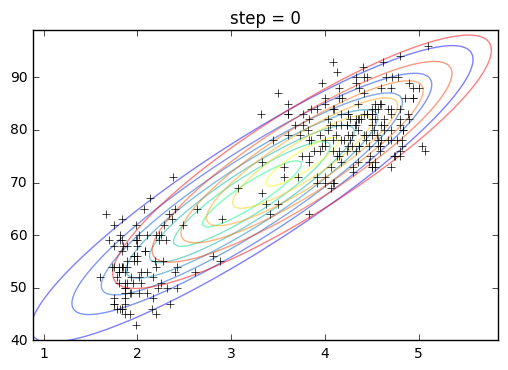

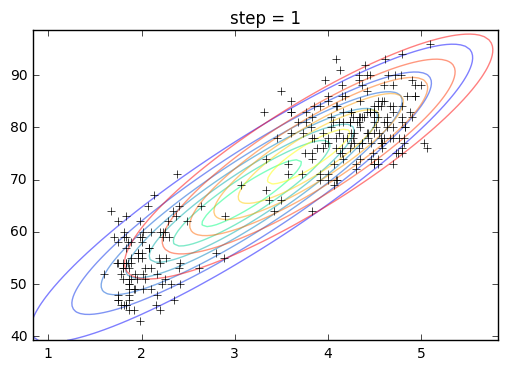

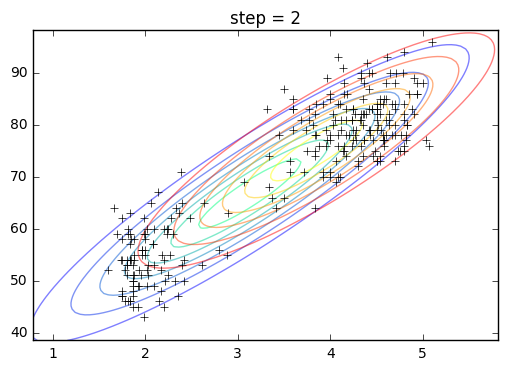

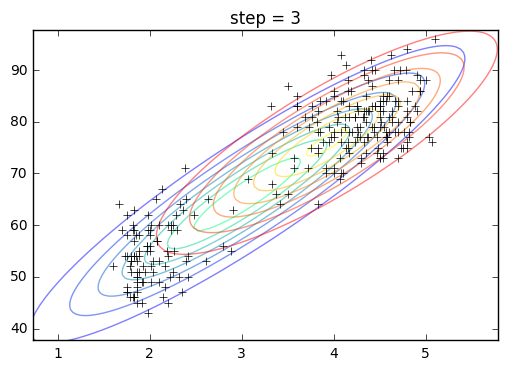

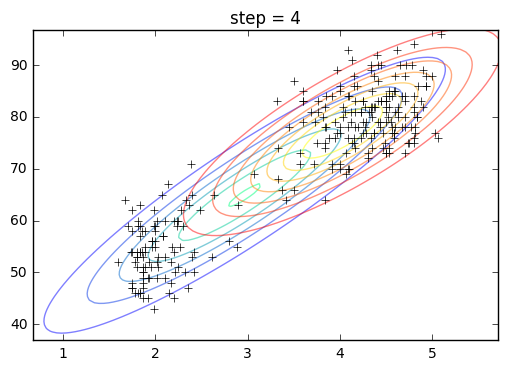

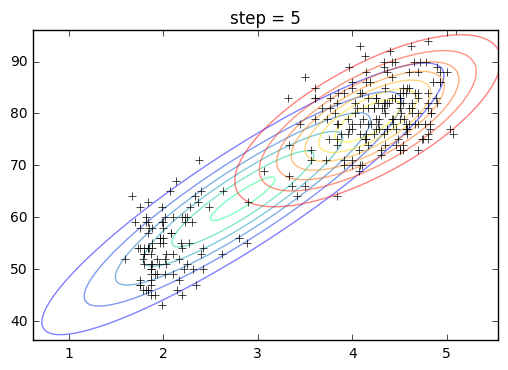

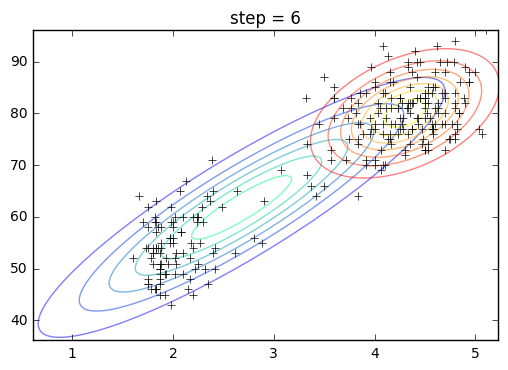

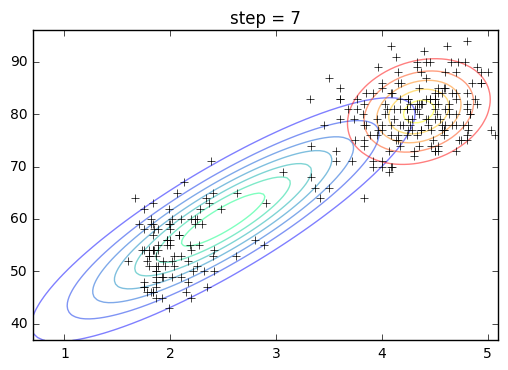

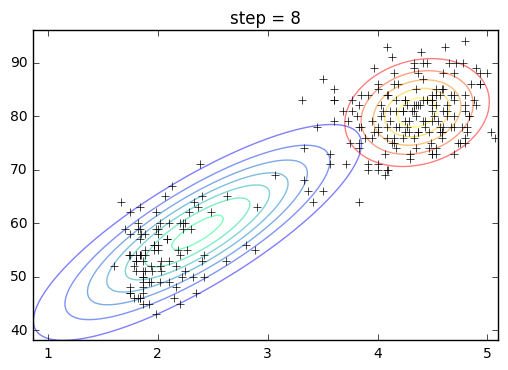

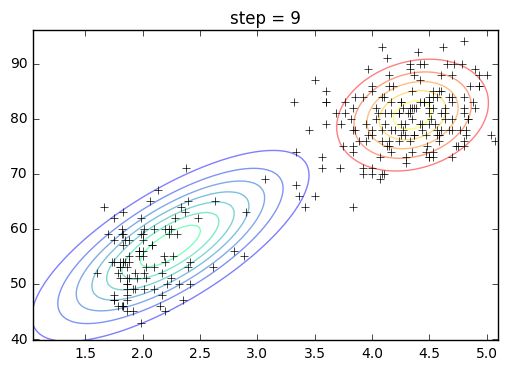

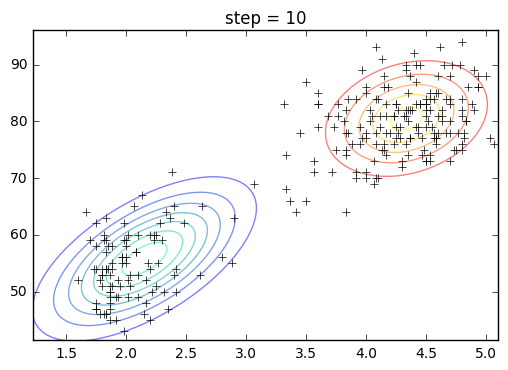

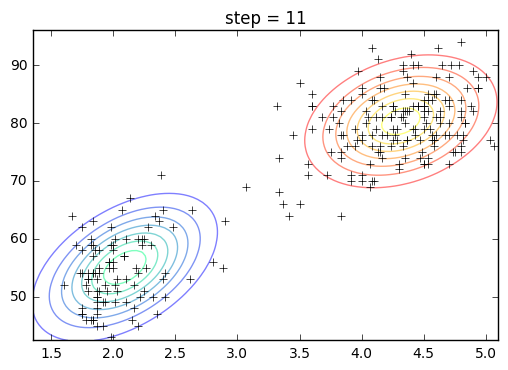

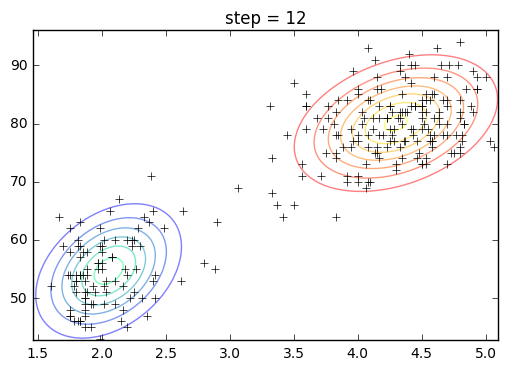

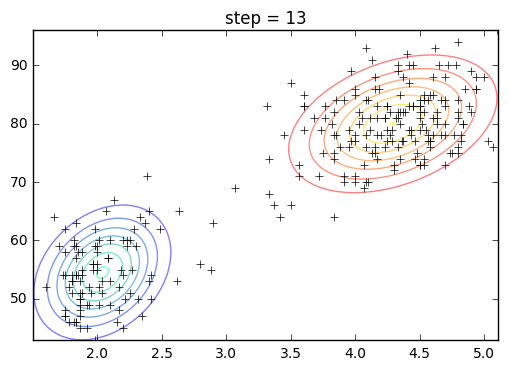

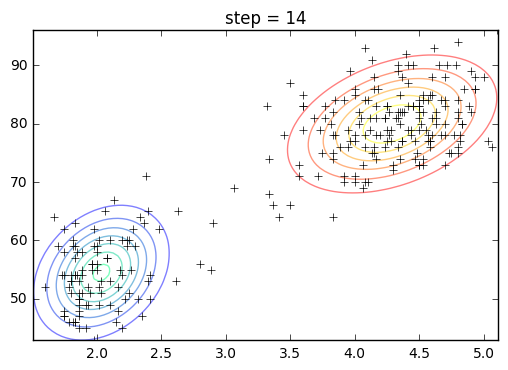

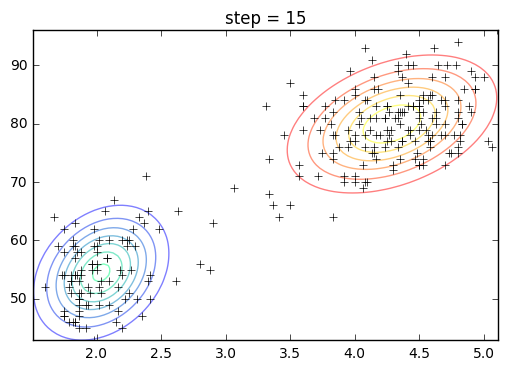

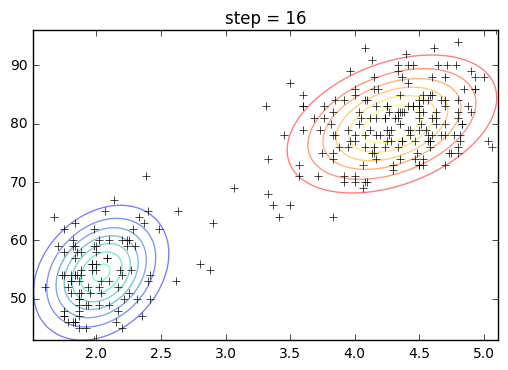

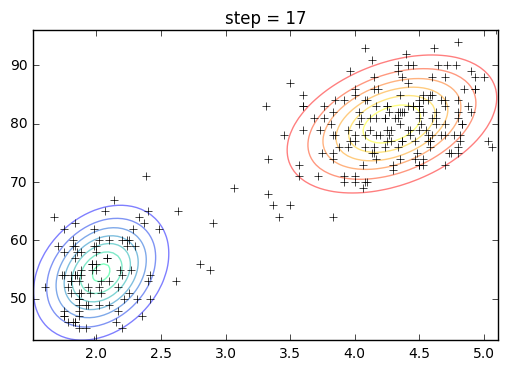

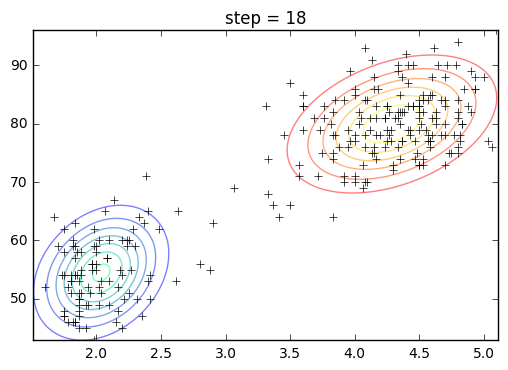

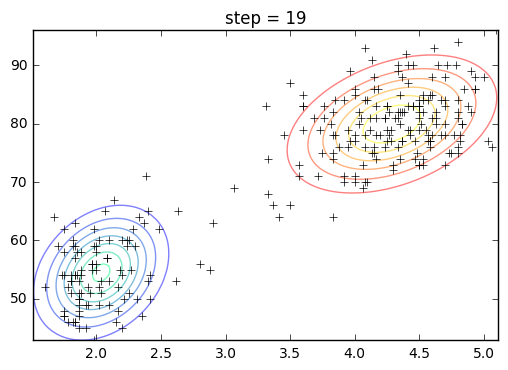

In [38]:
mean1 = data[:,0].mean ()
mean2 = data[:,1].mean ()
std1  = data[:,0].std ()
std2  = data[:,1].std ()
params = np.array ( [(mean1 - 0.2, mean2 - 1, std1, std2, 0),
                     (mean1 + 0.2, mean2 + 1, std1, std2, 0)] )
weights = np.array ( [ 0.5, 0.5 ] )
Q0=Q_i (data,params,weights )
EM(data,Q0,params,weights, 20)
